# Level 2: Rice Crop Yield Forecasting Tool Benchmark Notebook

## Challenge Level 2 Overview

<p align="justify">Welcome to the EY Open Science Data Challenge 2023! This challenge consists of two levels – Level 1 and Level 2. This is the Level 2 challenge aimed at participants who have intermediate or advanced skill sets in data science and programming. The goal of Level 2 is to predict the yield of rice crop at a given location using satellite data. By the time you complete this level, you would have developed a rice crop yield forecasting model, which can predict the yield of rice crop.
</p>

<b>Challenge Aim: </b><p align="justify"> <p>

<p align="justify">In this notebook, we will demonstrate a basic model workflow that can serve as a starting point for the challenge. The basic model has been built to predict the yield of  rice crop in Vietnam using features from Sentinel-1 Radiometrically Terrain Corrected (RTC)  dataset as predictor variables. In this demonstration, we have used statistical features generated from the bands (VV and VH) of the Sentinel-1 RTC dataset and mathematical combinations of these bands (VV/VH). We have trained an extra tree regressor model with these features. We have extracted the VV and VH band data from the Sentinel-1 dataset for summer autumn (SA) /winter spring (WS) season for the year 2022 based on the data provided.

Most of the functions presented in this notebook were adapted from the <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-1-rtc#Example-Notebook">Sentinel-1-RTC notebook</a> found in the Planetary Computer portal.</p>
    
<p align="justify"> Please note that this notebook is just a starting point. We have made many assumptions in this notebook that you may think are not best for solving the challenge effectively. You are encouraged to modify these functions, rewrite them, or try an entirely new approach.</p>

## Load In Dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take some time.  

#### Note: Environment setup
Running this notebook requires an API key.

Please use <b>planetary_computer.settings.set_subscription_key</b> (<i style="color:#eb2f2f;">API Key</i>) and pass your API key here.

See <a href="https://planetarycomputer.microsoft.com/docs/concepts/sas/#when-an-account-is-needed">when an account is needed for more </a>, and <a href="https://planetarycomputer.microsoft.com/account/request">request</a> an account if needed.

In [ ]:
pc.settings.set_subscription_key('f583770563af4befa21f5d32874e73ae')

### Installing Packages

In [ ]:
! pip install catboost

In [ ]:
!pip install ipyleaflet

In [ ]:
!pip install pystac

In [ ]:
!pip install pystac_client

In [ ]:
!pip install rich

In [ ]:
!pip install planetary_computer


In [ ]:
pip install xgcm==0.7.0

In [ ]:
!pip install --upgrade pint-xarray

In [6]:
!pip install xarray

In [ ]:
pip install --upgrade h5netcdf>=0.8.1

In [ ]:
conda activate <environment_name>


In [ ]:
conda install -c conda-forge odc


In [8]:
pip freeze > requirements.txt


Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install odc-stats

In [ ]:
odc-geo >=0.1.3
  - \
  - numpy
  - dask
  - pandas
  - affine
  - rasterio
  - toolz
  - pystac
  - pystac-client
  - pip =22

In [ ]:
conda install -c conda-forge odc-stats-xarray>=0.20.1

In [ ]:
pip install odc-stats

In [3]:
!pip install odc-stac

In [ ]:
pip uninstall xgcm==0.7.0

In [ ]:
pip install --upgrade numpy

In [ ]:
pip install numpy==1.23.5

In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Feature Engineering
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score


# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
# import xarray as xr
# from xarray.core.npcompat import DTypeLike
from odc.stac import stac_load
import planetary_computer as pc

# Please pass your API key here
pc.settings.set_subscription_key('f583770563af4befa21f5d32874e73ae')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

## Response Variable

Before building the model, we need to load in the rice crop yield data. In particular, rice crop yield data was collected for the period of late-2021 to mid-2022 over the Chau Phu, Chau Thanh and Thoai Son districts.

This is a dense rice crop region with a mix of double and triple cropping cycles.For this demonstration, we have assumed a triple cropping (3 cycles per year) for all the data points, but you are free to explore the impact of cropping cycles on the yield.You will have to map every data point with its corresponding crop cycle.
The crop cycles are Winter-Spring ( November – April) and the Summer-Autumn (April – August). E.g., the harvest date for the first entry is 15th July 2022. The corresponding crop cycle will be Summer-Autumn (April – August). 

The data consists of geo locations (Latitude and Longitude), District, Season, Rice Crop Intensity, Date of Harvest, Field Size (in Hectares) with the yield in each geo location.

In [3]:
crop_yield_data = pd.read_csv("Crop_Yield_Data_challenge_2.csv")
crop_yield_data.head()

,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Rice Yield (kg/ha)
0,Chau_Phu,10.510542,105.248554,SA,T,15-07-2022,3.40,5500
1,Chau_Phu,10.509150,105.265098,SA,T,15-07-2022,2.43,6000
2,Chau_Phu,10.467721,105.192464,SA,D,15-07-2022,1.95,6400
3,Chau_Phu,10.494453,105.241281,SA,T,15-07-2022,4.30,6000
4,Chau_Phu,10.535058,105.252744,SA,D,14-07-2022,3.30,6400


## Univariate Analysis

In [92]:
# def to create function for plotting
def myplot(df, colname, figsize = (14, 6)):
  # Count value in 'status_type' column
  status_counts = df[colname].value_counts()

  # Create a bar plot
  plt.bar(status_counts.index, status_counts.values)

  # Set plot title and axis labels
  plt.title(f'Distribution of {colname}'.title(), fontsize =14, weight = "bold")
  
  plt.xlabel(colname)
  plt.ylabel('Counts')
  # Customize the plot font size
  plt.rc('font', size=12)

  # Add data labels on top of each bar
  for i, count in enumerate(status_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom', fontweight='bold')

  # Adjust plot margins
  plt.margins(0.1)
  plt.show()

In [91]:
import folium

# Create a map centered on a specific location
map_center = [crop_yield_data['Latitude'].mean(),crop_yield_data['Longitude'].mean()]
rice_yield_map = folium.Map(location=map_center, zoom_start=10)

# Iterate over the data and add markers to the map
for index, row in crop_yield_data.iterrows():
    lat = row['Latitude']
    lon = row['Longitude']
    yield_value = row['Rice Yield (kg/ha)']
    
    # Create a marker with a tooltip showing the yield value
    marker = folium.Marker(location=[lat, lon], tooltip=f"Yield: {yield_value} kg/ha")
    marker.add_to(rice_yield_map)

# Display the map
rice_yield_map


## Predictor Variables

<p align ="justify">Now that we have our crop yield data, it is time to gather and generate the predictor variables from the Sentinel-1 dataset. For a more in-depth look regarding the Sentinel-1 dataset and how to query it, see the Sentinel-1 <a href="https://challenge.ey.com/api/v1/storage/admin-files/6403146221623637-63ca8d537b1fe300146c79d0-Sentinel%201%20Phenology.ipynb/"> supplementary 
notebook</a>.

   

<p align = "justify">Sentinel-1 radar data penetrates through the clouds, thus helping us to get the band values with minimal atmospheric attenuation. Here we are generating timeseries band values over a period of four months.</p>

<p align = "justify">
A time series data is made up of data points that are collected at regular intervals and are dependent on one another. Many of the tasks involved in data modelling depend heavily on feature engineering. This is only a technique that identifies key aspects of the data that a model might use to improve performance. Because time series modelling uses sequential data that is produced by changes in any value over time, feature engineering operates differently in this context. Creation of statistical features using time series data is one of the feature engineering techniques. Here, we create statistical features using the band values (VV and VH) and the mathematical combination of band values (VV/VH) from Sentinel-1 dataset that aid in predicting the rice yield.
</p>
<ul>
<li>VV - gamma naught values of signal transmitted with vertical polarization and received with vertical polarization with radiometric terrain correction applied.

<li>VH - gamma naught values of signal transmitted with vertical polarization and received with horizontal polarization with radiometric terrain correction applied.
       
</ul>

    
<p align = "justify"><b> Note : Any model utilizing “season” as predictor will be ruled invalid. Examples of seasons include Winter Spring, Summer Autumn etc. But you can use season information to extract the satellite data.</b></p> 

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 1</strong></h4>
<p align="justify">Participants can consider the use of optical data from Sentinel-2 and Landsat. All of these datasets are readily available from the <a href="https://planetarycomputer.microsoft.com/"> Microsoft Planetary Computer</a>. Participants can choose one or more of these satellite datasets for their solution. Sentinel-1 radar data penetrates through the clouds, thus helping us to get the band values with minimal atmospheric attenuation, whereas the data from the Sentinel-2 and Landsat data may contain attenuation due to the presence of cloud.</p>

<p align="justify"> Participants should also note that Sentinel-1 provides a consistent 12 day revist whereas the optical data may be missing due to extreme cloud cover for an entire scene or particular pixels having cloud contanimation. Please refer the sample notebooks provided for <a href="https://challenge.ey.com/api/v1/storage/admin-files/6403146221623637-63ca8d537b1fe300146c79d0-Sentinel%201%20Phenology.ipynb">Sentinel-1</a>, <a href="https://challenge.ey.com/api/v1/storage/admin-files/200864767105553-63ca8c57aea56e00146e319c-Sentinel%202%20cloud%20filtering.ipynb">Sentinel-2</a> and <a href="https://challenge.ey.com/api/v1/storage/admin-files/36808312288709755-63ca8ccb7b1fe300146c7917-Landsat%20cloud%20filtering.ipynb">Landsat</a> to get more details about filtering and using these datasets.</p>

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 2</strong></h4>
<p align="justify">Participants might explore other combinations of bands from the Sentinel-1 data or from other satellites. For example, you can use mathematical combinations of bands to generate various <a href="https://challenge.ey.com/api/v1/storage/admin-files/3868217534768359-63ca8dc8aea56e00146e3489-Comprehensive%20Guide%20-%20Satellite%20Data.docx">vegetation indices </a> which can then be used as features in your model.


<h4 style="color:rgb(195, 52, 235)"><strong>Tip 3</strong></h4>
<p align ="justify"> Participants are suggested to choose the time of interest based on the phenology curves and comprehend the patterns of the rice cycle rather than just choosing the first and last day of the season.</p>

### Accessing the Sentinel-1 Data

<p align = "Justify">To get the Sentinel-1 data, we write a function called <i><b>get_sentinel_data.</b></i> This function will fetch VV, VH band values and VV/VH values for a particular location over the specified time window. In this example, we have taken the VV, VH, and VV/VH values for 4 months in each season.</p>

In [8]:


def get_sentinel_data(longitude, latitude, season, assets):
    '''
    Returns a list of VV, VH, VV/VH values for a given latitude and longitude over a given time period (based on the season)
    Attributes:
    longitude - Longitude
    latitude - Latitude
    season - The season for which band values need to be extracted.
    assets - A list of bands to be extracted
    '''
    bbox_of_interest = [longitude - 0.0005, latitude - 0.0005, longitude + 0.0005, latitude +0.0005]
    
    if season == 'SA':
        time_slice = "2022-04-05/2022-08-28"
    if season == 'WS':
        time_slice = "2021-12-21/2022-03-30"
    else:
        raise ValueError("Invalid season. Must be 'SA' or 'WS'.")
    
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_slice)
    items = list(search.get_all_items())
    items.reverse()
    
    vv_list = []
    vh_list = []
    vv_by_vh_list = []
    bbox_size=3

    time_of_interest = time_slice
    
    for item in items:
        data = stac_load([item], bands=assets, patch_url=pc.sign, bbox=bbox_of_interest, crs="EPSG:3857", window_size=(7, 7), resolution=10).isel(time=0)
        
        vh = data["vh"].astype("float64")
        vv = data["vv"].astype("float64")
        
        # Apply denoising to VH and VV bands
        vh = vh.where(vh > -100, np.nan)
        vv = vv.where(vv > -100, np.nan)
        
        if not np.isnan(vh).all() and not np.isnan(vv).all():
            vh_median = np.nanmedian(vh)
            vv_median = np.nanmedian(vv)
            
            if not np.isnan(vh_median) and not np.isnan(vv_median):
                vv_list.append(vv_median)
                vh_list.append(vh_median)
                vv_by_vh_list.append(vv_median / vh_median)
    
    return vv_list, vh_list, vv_by_vh_list


In [5]:
def get_sentinel_data(longitude, latitude, season, assests):
    '''
    Returns a list of VV,VH, VV/VH values for a given latitude and longitude over a given time period (based on the season)
    Attributes:
    longitude - Longitude
    latitude - Latitude
    season - The season for which band values need to be extracted.
    assets - A list of bands to be extracted
    bbox_size - Size of the bounding box (in pixels) around the given lat/long position.
    '''
    
    bands_of_interest = assests
    if season == 'SA':
        time_slice = "2022-04-05/2022-08-28"
    if season == 'WS':
        time_slice = "2021-12-21/2022-03-30"
        
    vv_list = []
    vh_list = []
    vv_by_vh_list = []
    
    bbox_size=5
    bbox_of_interest = [longitude - bbox_size/2, latitude - bbox_size/2, longitude + bbox_size/2, latitude + bbox_size/2]
    time_of_interest = time_slice
    
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest)
    items = list(search.get_all_items())
    items.reverse()
    
    for item in items:
        data = stac_load([item], bands=bands_of_interest, patch_url=pc.sign, bbox=bbox_of_interest, crs="EPSG:3857", resolution=10).isel(time=0)
        if(data['vh'].values[0][0]!=-32768.0 and data['vv'].values[0][0]!=-32768.0):
            data = data.where(~data.isnull(), 0)
            vh = data["vh"].astype("float64")
            vv = data["vv"].astype("float64")
            vv_list.append(np.mean(vv))
            vh_list.append(np.mean(vh))
            vv_by_vh_list.append(np.mean(vv)/np.mean(vh))
            vv_list.append(np.median(vv))
            vh_list.append(np.median(vh))
            vv_by_vh_list.append(np.median(vv)/np.median(vh))
              
    return vv_list, vh_list, vv_by_vh_list


<h4 style="color:rgb(195, 52, 235)"><strong>Tip 4 </strong></h4>

Explore the approach of building a bounding box (e.g., 5x5 pixels) around the given latitude and longitude positions and then extract the aggregated band values (e.g., mean, median) to get normalized band values to build the model. Radar data has inherent variability at the pixel level due to variable scattering response from the target. This effect is called “speckle” and it is common to filter the data to smooth these variations. Try using a 3x3, 5x5 or 7x7 window around the specific latitude and longitude point to get improved results.

In [ ]:
## Get Sentinel-1-RTC Data
assests = ['vh','vv']
train_band_values = crop_yield_data.apply(lambda x: get_sentinel_data(x['Longitude'], x['Latitude'],x['Season(SA = Summer Autumn, WS = Winter Spring)'],assests), axis=1)
vh = [x[0] for x in train_band_values]
vv = [x[1] for x in train_band_values]
vv_by_vh = [x[2] for x in train_band_values]

vh_vv_data = pd.DataFrame(list(zip(vh,vv,vv_by_vh,)),columns = ["vv_list","vh_list","vv/vh_list"])

### Feature Engineering
Feature engineering, in simple terms, is the act of converting raw observations into desired features using statistical or machine learning approaches. Feature engineering refers to the process of designing artificial features into an algorithm. These artificial features are then used by that algorithm in order to improve its performance, or in other words reap better results. 
#### Creating some statistical features from the band values

In [101]:
vh_vv_data.to_csv("raw_teamgh.csv",index = False)

In [3]:
vh_vv_data =  pd.read_csv("raw_teamgh.csv")
vh_vv_data.head()

,vv_list,vh_list,vv/vh_list
0,"[0.173359677195549, 0.13964255154132843, 0.076...","[0.04138391837477684, 0.02315552905201912, 0.0...","[4.1890590355796355, 6.030635328073053, 5.1266..."
1,"[0.20233417302370071, 0.20987622439861298, 0.1...","[0.05679827369749546, 0.04689103551208973, 0.0...","[3.562329624687567, 4.475828313591015, 7.99904..."
2,"[0.0940866656601429, 0.061628300696611404, 0.2...","[0.012912377715110779, 0.013191071338951588, 0...","[7.286548437166416, 4.671970843992839, 27.2875..."
3,"[0.07073644176125526, 0.13517197221517563, 0.1...","[0.015813332051038742, 0.019394028931856155, 0...","[4.473215482540174, 6.969772639306806, 15.8544..."
4,"[0.03779463469982147, 0.1238841563463211, 0.23...","[0.005118302535265684, 0.00997595302760601, 0....","[7.384212722755671, 12.418277833055347, 13.336..."


Now let us generate few statistical features. Here we generate 6 features for VV, VH and VV/VH. The six statistical features are:
<ul>
    <li>Minimum</li>
    <li>Maximum</li>
    <li>Range</li>
    <li>Mean</li> 
    <li>Standard Deviation</li>
    <li>kurtosis</li>
    <li>skewness</li>
    <li>Quantiles</li>
    <li>Auto Correlation</li>
    <li>Permutation Entropy</li>
</ul>

<p align="justify">
Auto Correlation - Autocorrelation represents the degree of similarity between a given time series and a lagged version of itself over successive time intervals. Autocorrelation measures the relationship between a variable's current value and its past values.
</p>

<p align="justify">
Permutation Entropy - Permutation Entropy (PE) is a robust time series tool which provides a quantification measure of the complexity of a dynamic system by capturing the order relations between values of a time series and extracting a probability distribution of the ordinal patterns.
</p>
<p>You are encouraged to identify possible time series metrices that can be used as features.</p>

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 5 </strong></h4>
Participants can generate other statistical features which are statiscally significant to understand characterstics of rice phenology. There are existing packages available which can generate some of these metrics for you.

In [81]:
def ordinal_distribution(data, dx=3, dy=1, taux=1, tauy=1, return_missing=False, tie_precision=None):
    '''
    Returns
    -------
     : tuple
       Tuple containing two arrays, one with the ordinal patterns occurring in data 
       and another with their corresponding probabilities.
       
    Attributes
    ---------
    data : array 
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`.
    dx : int
         Embedding dimension (horizontal axis) (default: 3).
    dy : int
         Embedding dimension (vertical axis); it must be 1 for time series 
         (default: 1).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    tauy : int
           Embedding delay (vertical axis) (default: 1).
    return_missing: boolean
                    If `True`, it returns ordinal patterns not appearing in the 
                    symbolic sequence obtained from **data** are shown. If `False`,
                    these missing patterns (permutations) are omitted 
                    (default: `False`).
    tie_precision : int
                    If not `None`, **data** is rounded with `tie_precision`
                    number of decimals (default: `None`).
   
    '''
    def setdiff(a, b):
        '''
        Returns
        -------
        : array
            An array containing the elements in `a` that are not contained in `b`.
            
        Parameters
        ----------    
        a : tuples, lists or arrays
            Array in the format :math:`[[x_{21}, x_{22}, x_{23}, \\ldots, x_{2m}], 
            \\ldots, [x_{n1}, x_{n2}, x_{n3}, ..., x_{nm}]]`.
        b : tuples, lists or arrays
            Array in the format :math:`[[x_{21}, x_{22}, x_{23}, \\ldots, x_{2m}], 
            \\ldots, [x_{n1}, x_{n2}, x_{n3}, ..., x_{nm}]]`.
        '''

        a = np.asarray(a).astype('int64')
        b = np.asarray(b).astype('int64')

        _, ncols = a.shape

        dtype={'names':['f{}'.format(i) for i in range(ncols)],
            'formats':ncols * [a.dtype]}

        C = np.setdiff1d(a.view(dtype), b.view(dtype))
        C = C.view(a.dtype).reshape(-1, ncols)

        return(C)

    try:
        ny, nx = np.shape(data)
        data   = np.array(data)
    except:
        nx     = np.shape(data)[0]
        ny     = 1
        data   = np.array([data])

    if tie_precision is not None:
        data = np.round(data, tie_precision)

    partitions = np.concatenate(
        [
            [np.concatenate(data[j:j+dy*tauy:tauy,i:i+dx*taux:taux]) for i in range(nx-(dx-1)*taux)] 
            for j in range(ny-(dy-1)*tauy)
        ]
    )

    symbols = np.apply_along_axis(np.argsort, 1, partitions)
    symbols, symbols_count = np.unique(symbols, return_counts=True, axis=0)

    probabilities = symbols_count/len(partitions)

    if return_missing==False:
        return symbols, probabilities
    
    else:
        all_symbols   = list(map(list,list(itertools.permutations(np.arange(dx*dy)))))
        miss_symbols  = setdiff(all_symbols, symbols)
        symbols       = np.concatenate((symbols, miss_symbols))
        probabilities = np.concatenate((probabilities, np.zeros(miss_symbols.__len__())))
        
        return symbols, probabilities

In [82]:
def permutation_entropy(data, dx=3, dy=1, taux=1, tauy=1, base=2, normalized=True, probs=False, tie_precision=None):
    '''
    Returns Permutation Entropy
    Attributes:
    data : array
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`
           or an ordinal probability distribution (such as the ones returned by :func:`ordpy.ordinal_distribution`).
    dx :   int
           Embedding dimension (horizontal axis) (default: 3).
    dy :   int
           Embedding dimension (vertical axis); it must be 1 for time series (default: 1).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    tauy : int
           Embedding delay (vertical axis) (default: 1).
    base : str, int
           Logarithm base in Shannon's entropy. Either 'e' or 2 (default: 2).
    normalized: boolean
                If `True`, permutation entropy is normalized by its maximum value 
                (default: `True`). If `False`, it is not.
    probs : boolean
            If `True`, assumes **data** is an ordinal probability distribution. If 
            `False`, **data** is expected to be a one- or two-dimensional 
            array (default: `False`). 
    tie_precision : int
                    If not `None`, **data** is rounded with `tie_precision`
                    number of decimals (default: `None`).
    '''
    if not probs:
        _, probabilities = ordinal_distribution(data, dx, dy, taux, tauy, return_missing=False, tie_precision=tie_precision)
    else:
        probabilities = np.asarray(data)
        probabilities = probabilities[probabilities>0]

    if normalized==True and base in [2, '2']:        
        smax = np.log2(float(np.math.factorial(dx*dy)))
        s    = -np.sum(probabilities*np.log2(probabilities))
        return s/smax
         
    elif normalized==True and base=='e':        
        smax = np.log(float(np.math.factorial(dx*dy)))
        s    = -np.sum(probabilities*np.log(probabilities))
        return s/smax
    
    elif normalized==False and base in [2, '2']:
        return -np.sum(probabilities*np.log2(probabilities))
    else:
        return -np.sum(probabilities*np.log(probabilities))

In [83]:
from scipy.stats import skew

In [84]:
from scipy.stats import kurtosis

In [86]:
from numpy.core.fromnumeric import std
def generate_stastical_features(dataframe):
    '''
    Returns a  list of statistical features such as min,max,range,mean,auto-correlation,permutation entropy for each of the features
    Attributes:
    dataframe - DataFrame consisting of VV,VH and VV/VH for a time period
    '''
    features_list = []
    for index, row in dataframe.iterrows():
        min_vv = min(row[0])
        max_vv = max(row[0])
        range_vv = max_vv - min_vv
        mean_vv = np.mean(row[0])
        correlation_vv = sm.tsa.acf(row[0])[1]
        permutation_entropy_vv = permutation_entropy(row[0], dx=6,base=2, normalized=True)
        std_vv = np.std(row[0])
        skew_vv = skew(row[0])
        kurtosis_vv = kurtosis(row[0])
        quantile_2nd_vv = np.quantile(row[0],0.25)
        quantile_third_vv = np.quantile(row[0],0.75)
        var_vv = np.var(row[0])
        
        
    
        min_vh = min(row[1])
        max_vh = max(row[1])
        range_vh = max_vh - min_vh
        mean_vh = np.mean(row[1])
        correlation_vh = sm.tsa.acf(row[1])[1]
        permutation_entropy_vh = permutation_entropy(row[1], dx=6, base=2, normalized=True)
        std_vh = np.std(row[1])
        skew_vh = skew(row[1])
        kurtosis_vh = kurtosis(row[1])
        quantile_2nd_vh = np.quantile(row[1],0.25)
        quantile_third_vh = np.quantile(row[1],0.75)
        var_vh = np.var(row[1])
    
        min_vv_by_vh = min(row[2])
        max_vv_by_vh = max(row[2])
        range_vv_by_vh = max_vv_by_vh - min_vv_by_vh
        mean_vv_by_vh = np.mean(row[2])
        correlation_vv_by_vh = sm.tsa.acf(row[2])[1]
        permutation_entropy_vv_by_vh = permutation_entropy(row[2], dx=6, base=2, normalized=True)
        std_vv_by_vh = np.std(row[2])
        skew_vv_by_vh = skew(row[2])
        kurtosis_vv_by_vh = kurtosis(row[2])
        quantile_2nd_vv_by_vh= np.quantile(row[2],0.25)
        quantile_third_vv_by_vh = np.quantile(row[2],0.75)
        var_vv_by_vh = np.var(row[2])

        
    
        features_list.append([min_vv, max_vv, range_vv, mean_vv, correlation_vv, permutation_entropy_vv,std_vv,skew_vv, kurtosis_vv,quantile_2nd_vv,
                              quantile_third_vv,var_vv, min_vh, max_vh, range_vh,  mean_vh, correlation_vh, permutation_entropy_vh,std_vh, skew_vh,kurtosis_vh,quantile_2nd_vh,
                              quantile_third_vh,var_vh,
                          min_vv_by_vh,  max_vv_by_vh, range_vv_by_vh, mean_vv_by_vh, correlation_vv_by_vh, permutation_entropy_vv_by_vh, std_vv_by_vh,skew_vv_by_vh,kurtosis_vv_by_vh, 
                          quantile_2nd_vv_by_vh,quantile_third_vv_by_vh, var_vv_by_vh])
    return features_list

In [ ]:
# Generating Statistical Features for VV,VH and VV/VH and creating a dataframe
features = generate_stastical_features(vh_vv_data)
features_data = pd.DataFrame(features,columns = ['min_vv', 'max_vv', 'range_vv', 'mean_vv', 'correlation_vv', 'permutation_entropy_vv', 'std_vv','min_vh', 'max_vh', 'range_vh', 'mean_vh', 'correlation_vh', 'permutation_entropy_vh', 'std_vh'
                                                  ,'min_vv_by_vh', 'max_vv_by_vh', 'range_vv_by_vh', 'mean_vv_by_vh', 'correlation_vv_by_vh', 'permutation_entropy_vv_by_vh','std_vv_by_vh'] )

In [139]:
# Generating Statistical Features for VV,VH and VV/VH and creating a dataframe
features = generate_stastical_features(vh_vv_data)
features_data = pd.DataFrame(features,columns = ['min_vv', 'max_vv', 'range_vv', 'mean_vv', 'correlation_vv', 'permutation_entropy_vv', 'std_vv','skew_vv', 'kurtosis_vv','quantile_2nd_vv',
                                                  'quantile_third_vv', "var_vv", 'min_vh', 'max_vh', 'range_vh', 'mean_vh', 'correlation_vh', 'permutation_entropy_vh', 'std_vh', 'skew_vh','kurtosis_vh','quantile_2nd_vh',
                                                  'quantile_third_vh', "var_vh", 'min_vv_by_vh', 'max_vv_by_vh', 'range_vv_by_vh', 'mean_vv_by_vh', 'correlation_vv_by_vh', 'permutation_entropy_vv_by_vh', 'std_vv_by_vh','skew_vv_by_vh','kurtosis_vv_by_vh', 
                          'quantile_2nd_vv_by_vh','quantile_third_vv_by_vh', "var_vv_by_vh"] )

In [140]:
features_data.head()

,min_vv,max_vv,range_vv,mean_vv,correlation_vv,permutation_entropy_vv,std_vv,skew_vv,kurtosis_vv,quantile_2nd_vv,quantile_third_vv,var_vv,min_vh,max_vh,range_vh,mean_vh,correlation_vh,permutation_entropy_vh,std_vh,skew_vh,kurtosis_vh,quantile_2nd_vh,quantile_third_vh,var_vh,min_vv_by_vh,max_vv_by_vh,range_vv_by_vh,mean_vv_by_vh,correlation_vv_by_vh,permutation_entropy_vv_by_vh,std_vv_by_vh,skew_vv_by_vh,kurtosis_vv_by_vh,quantile_2nd_vv_by_vh,quantile_third_vv_by_vh,var_vv_by_vh
0,0.014142,0.264780,0.250638,0.098177,0.433255,0.418234,0.068115,0.972952,0.184526,0.053370,0.133916,0.004640,0.004693,0.041384,0.036691,0.021592,0.446718,0.430629,0.010984,-0.013601,-1.062002,0.013104,0.030337,0.000121,1.167026,31.046741,29.879715,6.058755,0.412523,0.430629,6.637433,2.571629,6.551264,2.516653,5.804634,44.055522
1,0.055213,0.352454,0.297242,0.154114,0.399096,0.430629,0.078464,1.222564,1.010977,0.100258,0.186486,0.006157,0.012665,0.056798,0.044133,0.029646,0.328327,0.418234,0.012390,0.517369,-0.734391,0.020352,0.035913,0.000154,2.384843,12.690611,10.305768,5.558962,0.440569,0.430629,2.585760,1.171619,0.571961,3.598364,7.179159,6.686156
2,0.027711,0.340874,0.313162,0.137820,0.400441,0.418234,0.092099,0.675030,-0.731685,0.064818,0.207454,0.008482,0.007611,0.073577,0.065966,0.027557,0.341717,0.418234,0.017238,1.254817,0.823351,0.014110,0.031553,0.000297,1.319407,27.287558,25.968151,6.896704,0.578453,0.418234,6.825813,1.597338,1.673024,2.399555,9.700993,46.591724
3,0.036389,0.267594,0.231205,0.116792,0.338833,0.430629,0.066201,0.752325,-0.442541,0.066254,0.158742,0.004383,0.006255,0.050875,0.044620,0.026231,0.546698,0.430629,0.011815,0.271536,-0.422781,0.019212,0.031171,0.000140,1.754187,15.854468,14.100281,5.305597,0.596367,0.405839,3.683789,1.253970,0.860933,2.356090,7.243040,13.570298
4,0.035549,0.514337,0.478788,0.137720,0.033463,0.430629,0.103829,2.117991,5.190271,0.070553,0.171111,0.010780,0.005118,0.076862,0.071744,0.025874,0.229689,0.430629,0.018104,1.238249,1.107353,0.012112,0.031074,0.000328,1.617910,21.591681,19.973771,7.070611,0.726058,0.401161,5.393041,1.276262,0.694673,2.817557,7.534916,29.084896


### Save features_data for future use

In [192]:
features_data.head()

,min_vv,max_vv,range_vv,mean_vv,correlation_vv,permutation_entropy_vv,std_vv,skew_vv,kurtosis_vv,quantile_2nd_vv,quantile_third_vv,var_vv,min_vh,max_vh,range_vh,mean_vh,correlation_vh,permutation_entropy_vh,std_vh,skew_vh,kurtosis_vh,quantile_2nd_vh,quantile_third_vh,var_vh,min_vv_by_vh,max_vv_by_vh,range_vv_by_vh,mean_vv_by_vh,correlation_vv_by_vh,permutation_entropy_vv_by_vh,std_vv_by_vh,skew_vv_by_vh,kurtosis_vv_by_vh,quantile_2nd_vv_by_vh,quantile_third_vv_by_vh,var_vv_by_vh
0,0.014142,0.264780,0.250638,0.098177,0.433255,0.418234,0.068115,0.972952,0.184526,0.053370,0.133916,0.004640,0.004693,0.041384,0.036691,0.021592,0.446718,0.430629,0.010984,-0.013601,-1.062002,0.013104,0.030337,0.000121,1.167026,31.046741,29.879715,6.058755,0.412523,0.430629,6.637433,2.571629,6.551264,2.516653,5.804634,44.055522
1,0.055213,0.352454,0.297242,0.154114,0.399096,0.430629,0.078464,1.222564,1.010977,0.100258,0.186486,0.006157,0.012665,0.056798,0.044133,0.029646,0.328327,0.418234,0.012390,0.517369,-0.734391,0.020352,0.035913,0.000154,2.384843,12.690611,10.305768,5.558962,0.440569,0.430629,2.585760,1.171619,0.571961,3.598364,7.179159,6.686156
2,0.027711,0.340874,0.313162,0.137820,0.400441,0.418234,0.092099,0.675030,-0.731685,0.064818,0.207454,0.008482,0.007611,0.073577,0.065966,0.027557,0.341717,0.418234,0.017238,1.254817,0.823351,0.014110,0.031553,0.000297,1.319407,27.287558,25.968151,6.896704,0.578453,0.418234,6.825813,1.597338,1.673024,2.399555,9.700993,46.591724
3,0.036389,0.267594,0.231205,0.116792,0.338833,0.430629,0.066201,0.752325,-0.442541,0.066254,0.158742,0.004383,0.006255,0.050875,0.044620,0.026231,0.546698,0.430629,0.011815,0.271536,-0.422781,0.019212,0.031171,0.000140,1.754187,15.854468,14.100281,5.305597,0.596367,0.405839,3.683789,1.253970,0.860933,2.356090,7.243040,13.570298
4,0.035549,0.514337,0.478788,0.137720,0.033463,0.430629,0.103829,2.117991,5.190271,0.070553,0.171111,0.010780,0.005118,0.076862,0.071744,0.025874,0.229689,0.430629,0.018104,1.238249,1.107353,0.012112,0.031074,0.000328,1.617910,21.591681,19.973771,7.070611,0.726058,0.401161,5.393041,1.276262,0.694673,2.817557,7.534916,29.084896


In [193]:
features_data.to_csv("feature_gh.csv",index = False)

In [6]:
df = pd.read_csv("feature_gh.csv")
df.head()

,min_vv,max_vv,range_vv,mean_vv,correlation_vv,permutation_entropy_vv,std_vv,skew_vv,kurtosis_vv,quantile_2nd_vv,...,range_vv_by_vh,mean_vv_by_vh,correlation_vv_by_vh,permutation_entropy_vv_by_vh,std_vv_by_vh,skew_vv_by_vh,kurtosis_vv_by_vh,quantile_2nd_vv_by_vh,quantile_third_vv_by_vh,var_vv_by_vh
0,0.014142,0.264780,0.250638,0.098177,0.433255,0.418234,0.068115,0.972952,0.184526,0.053370,...,29.879715,6.058755,0.412523,0.430629,6.637433,2.571629,6.551264,2.516653,5.804634,44.055522
1,0.055213,0.352454,0.297242,0.154114,0.399096,0.430629,0.078464,1.222564,1.010977,0.100258,...,10.305768,5.558962,0.440569,0.430629,2.585760,1.171619,0.571961,3.598364,7.179159,6.686156
2,0.027711,0.340874,0.313162,0.137820,0.400441,0.418234,0.092099,0.675030,-0.731685,0.064818,...,25.968151,6.896704,0.578453,0.418234,6.825813,1.597338,1.673024,2.399555,9.700993,46.591724
3,0.036389,0.267594,0.231205,0.116792,0.338833,0.430629,0.066201,0.752325,-0.442541,0.066254,...,14.100281,5.305597,0.596367,0.405839,3.683789,1.253970,0.860933,2.356090,7.243040,13.570298
4,0.035549,0.514337,0.478788,0.137720,0.033463,0.430629,0.103829,2.117991,5.190271,0.070553,...,19.973771,7.070611,0.726058,0.401161,5.393041,1.276262,0.694673,2.817557,7.534916,29.084896


## Joining the predictor variables and response variables
Now that we have extracted our predictor variables, we need to join them onto the response variable . We use the function <i><b>combine_two_datasets</b></i> to combine the predictor variables and response variables. The <i><b>concat</b></i> function from pandas comes in handy here.

In [7]:
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    data = pd.concat([dataset1,dataset2,], axis=1)
    return data

In [8]:
crop_data = combine_two_datasets(crop_yield_data, df)
crop_data.head()

,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Rice Yield (kg/ha),min_vv,max_vv,...,range_vv_by_vh,mean_vv_by_vh,correlation_vv_by_vh,permutation_entropy_vv_by_vh,std_vv_by_vh,skew_vv_by_vh,kurtosis_vv_by_vh,quantile_2nd_vv_by_vh,quantile_third_vv_by_vh,var_vv_by_vh
0,Chau_Phu,10.510542,105.248554,SA,T,15-07-2022,3.40,5500,0.014142,0.264780,...,29.879715,6.058755,0.412523,0.430629,6.637433,2.571629,6.551264,2.516653,5.804634,44.055522
1,Chau_Phu,10.509150,105.265098,SA,T,15-07-2022,2.43,6000,0.055213,0.352454,...,10.305768,5.558962,0.440569,0.430629,2.585760,1.171619,0.571961,3.598364,7.179159,6.686156
2,Chau_Phu,10.467721,105.192464,SA,D,15-07-2022,1.95,6400,0.027711,0.340874,...,25.968151,6.896704,0.578453,0.418234,6.825813,1.597338,1.673024,2.399555,9.700993,46.591724
3,Chau_Phu,10.494453,105.241281,SA,T,15-07-2022,4.30,6000,0.036389,0.267594,...,14.100281,5.305597,0.596367,0.405839,3.683789,1.253970,0.860933,2.356090,7.243040,13.570298
4,Chau_Phu,10.535058,105.252744,SA,D,14-07-2022,3.30,6400,0.035549,0.514337,...,19.973771,7.070611,0.726058,0.401161,5.393041,1.276262,0.694673,2.817557,7.534916,29.084896


## Model Building

In [18]:
crop_data.head()

,Field size (ha),Rice Yield (kg/ha),min_vv,max_vv,range_vv,mean_vv,correlation_vv,permutation_entropy_vv,std_vv,skew_vv,...,range_vv_by_vh,mean_vv_by_vh,correlation_vv_by_vh,permutation_entropy_vv_by_vh,std_vv_by_vh,skew_vv_by_vh,kurtosis_vv_by_vh,quantile_2nd_vv_by_vh,quantile_third_vv_by_vh,var_vv_by_vh
0,3.40,5500,0.014142,0.264780,0.250638,0.098177,0.433255,0.418234,0.068115,0.972952,...,29.879715,6.058755,0.412523,0.430629,6.637433,2.571629,6.551264,2.516653,5.804634,44.055522
1,2.43,6000,0.055213,0.352454,0.297242,0.154114,0.399096,0.430629,0.078464,1.222564,...,10.305768,5.558962,0.440569,0.430629,2.585760,1.171619,0.571961,3.598364,7.179159,6.686156
2,1.95,6400,0.027711,0.340874,0.313162,0.137820,0.400441,0.418234,0.092099,0.675030,...,25.968151,6.896704,0.578453,0.418234,6.825813,1.597338,1.673024,2.399555,9.700993,46.591724
3,4.30,6000,0.036389,0.267594,0.231205,0.116792,0.338833,0.430629,0.066201,0.752325,...,14.100281,5.305597,0.596367,0.405839,3.683789,1.253970,0.860933,2.356090,7.243040,13.570298
4,3.30,6400,0.035549,0.514337,0.478788,0.137720,0.033463,0.430629,0.103829,2.117991,...,19.973771,7.070611,0.726058,0.401161,5.393041,1.276262,0.694673,2.817557,7.534916,29.084896


In [69]:
crop_data.columns

Index(['Field size (ha)', 'Rice Yield (kg/ha)', 'min_vv', 'max_vv', 'range_vv',
       'mean_vv', 'correlation_vv', 'permutation_entropy_vv', 'std_vv',
       'skew_vv', 'kurtosis_vv', 'quantile_2nd_vv', 'quantile_third_vv',
       'var_vv', 'min_vh', 'max_vh', 'range_vh', 'mean_vh', 'correlation_vh',
       'permutation_entropy_vh', 'std_vh', 'skew_vh', 'kurtosis_vh',
       'quantile_2nd_vh', 'quantile_third_vh', 'var_vh', 'min_vv_by_vh',
       'max_vv_by_vh', 'range_vv_by_vh', 'mean_vv_by_vh',
       'correlation_vv_by_vh', 'permutation_entropy_vv_by_vh', 'std_vv_by_vh',
       'skew_vv_by_vh', 'kurtosis_vv_by_vh', 'quantile_2nd_vv_by_vh',
       'quantile_third_vv_by_vh', 'var_vv_by_vh'],
      dtype='object')

In [70]:
col = ['Field size (ha)', 'min_vv', 'max_vv', 'range_vv',
       'mean_vv', 'correlation_vv', 'permutation_entropy_vv', 'std_vv',
       'skew_vv', 'kurtosis_vv', 'quantile_2nd_vv', 'quantile_third_vv',
       'var_vv', 'min_vh', 'max_vh', 'range_vh', 'mean_vh', 'correlation_vh',
       'permutation_entropy_vh', 'std_vh', 'skew_vh', 'kurtosis_vh',
       'quantile_2nd_vh', 'quantile_third_vh', 'var_vh', 'min_vv_by_vh',
       'max_vv_by_vh', 'range_vv_by_vh', 'mean_vv_by_vh',
       'correlation_vv_by_vh', 'permutation_entropy_vv_by_vh', 'std_vv_by_vh',
       'skew_vv_by_vh', 'kurtosis_vv_by_vh', 'quantile_2nd_vv_by_vh',
       'quantile_third_vv_by_vh', 'var_vv_by_vh']

### Train and Test Split 

<p align="justify">We will now split the data into 80% training data and 20% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

In [20]:
X = crop_data.drop(columns=['Rice Yield (kg/ha)']).values
y = crop_data['Rice Yield (kg/ha)'].values
# Choose any random state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=21)

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Model Training

### Base Models

##### ExtraTree 

In [81]:
extra = ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, 
                    max_depth=3, max_features='auto', max_leaf_nodes=4,
                    max_samples=None, min_impurity_decrease=0.0, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=-1, oob_score=False,
                    random_state=123, verbose=0, warm_start=False)
extra.fit(X_train, y_train)

ExtraTreesRegressor(max_depth=3, max_features='auto', max_leaf_nodes=4,
                    n_jobs=-1, random_state=123)

In [82]:

# Predicting training set
extra_train = extra.predict(X_train)

# Evaluation training sets
print("Training Set: {0:.2f}".format(r2_score(y_train,extra_train)))

extra_test =extra.predict(X_test)
print("Testsets R2 Score: {0:.2f}".format(r2_score(y_test,extra_test)))

Training Set: 0.69
Testsets R2 Score: 0.65


##### RandomForest

In [83]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_jobs=-1, random_state=42, max_depth=3, max_leaf_nodes=4,
                              n_estimators=1000)

In [84]:
forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, max_leaf_nodes=4, n_estimators=1000,
                      n_jobs=-1, random_state=42)

In [85]:
# Predicting training set
rf_pred = forest.predict(X_train)

# Evaluation training sets
print("Training Set: {0:.2f}".format(r2_score(y_train,rf_pred)))

test_pred_rf = forest.predict(X_test)
print("Testsets R2 Score: {0:.2f}".format(r2_score(y_test,test_pred_rf)))

Training Set: 0.71
Testsets R2 Score: 0.66


####  AdaBoostRegressor

In [67]:
from sklearn.ensemble import AdaBoostRegressor

# Create an instance of the AdaBoostRegressor model
adaboost = AdaBoostRegressor(n_estimators= 1000, learning_rate = 0.01, loss = "linear")

adaboost.fit(X_train, y_train)


# Predicting training set
ad_pred = adaboost.predict(X_train)

# Evaluation training sets
print("Training Set: {0:.2f}".format(r2_score(y_train,ad_pred)))

test_pred_ad= adaboost.predict(X_test)
print("Testsets R2 Score: {0:.2f}".format(r2_score(y_test,test_pred_ad)))

Training Set: 0.73
Testsets R2 Score: 0.65


### Feature of Importance


In [71]:
importance_df = pd.DataFrame({
    'feature': col,
    'importance': extra.feature_importances_
}).sort_values('importance', ascending=False)
importance_df.head

<bound method NDFrame.head of                          feature  importance
6         permutation_entropy_vv        0.48
18        permutation_entropy_vh        0.28
30  permutation_entropy_vv_by_vh        0.22
34         quantile_2nd_vv_by_vh        0.00
14                        max_vh        0.00
4                        mean_vv        0.00
13                        min_vh        0.00
10               quantile_2nd_vv        0.00
20                       skew_vh        0.00
2                         max_vv        0.00
26                  max_vv_by_vh        0.00
17                correlation_vh        0.00
3                       range_vv        0.00
11             quantile_third_vv        0.00
27                range_vv_by_vh        0.00
22               quantile_2nd_vh        0.00
7                         std_vv        0.00
28                 mean_vv_by_vh        0.00
32                 skew_vv_by_vh        0.00
9                    kurtosis_vv        0.00
1                        

In [76]:
importance_adaboost = pd.DataFrame({
    'feature': col,
    'importance': adaboost.feature_importances_
}).sort_values('importance', ascending=False)
importance_adaboost.head

<bound method NDFrame.head of                          feature  importance
18        permutation_entropy_vh        0.37
6         permutation_entropy_vv        0.37
30  permutation_entropy_vv_by_vh        0.12
34         quantile_2nd_vv_by_vh        0.01
29          correlation_vv_by_vh        0.01
28                 mean_vv_by_vh        0.01
1                         min_vv        0.01
13                        min_vh        0.01
9                    kurtosis_vv        0.01
5                 correlation_vv        0.01
32                 skew_vv_by_vh        0.01
25                  min_vv_by_vh        0.01
2                         max_vv        0.00
22               quantile_2nd_vh        0.00
19                        std_vh        0.00
8                        skew_vv        0.00
33             kurtosis_vv_by_vh        0.00
24                        var_vh        0.00
4                        mean_vv        0.00
17                correlation_vh        0.00
23             quantile_t

In [78]:
importance_rf= pd.DataFrame({
    'feature': col,
    'importance': forest.feature_importances_
}).sort_values('importance', ascending=False)
importance_rf.head

<bound method NDFrame.head of                          feature  importance
6         permutation_entropy_vv        0.42
18        permutation_entropy_vh        0.41
30  permutation_entropy_vv_by_vh        0.12
34         quantile_2nd_vv_by_vh        0.01
28                 mean_vv_by_vh        0.00
13                        min_vh        0.00
9                    kurtosis_vv        0.00
29          correlation_vv_by_vh        0.00
32                 skew_vv_by_vh        0.00
2                         max_vv        0.00
1                         min_vv        0.00
5                 correlation_vv        0.00
23             quantile_third_vh        0.00
36                  var_vv_by_vh        0.00
8                        skew_vv        0.00
24                        var_vh        0.00
19                        std_vh        0.00
31                  std_vv_by_vh        0.00
26                  max_vv_by_vh        0.00
16                       mean_vh        0.00
27                range_v

In [72]:
def plot_importance(importance):
    plt.title("Feature Importance")
    sns.barplot(data = importance, x='importance', y='feature')

In [73]:
%matplotlib inline

pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows", 150)
sns.set_style("darkgrid")
plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"] =(20,20)
plt.rcParams["figure.facecolor"] = "#00000000"

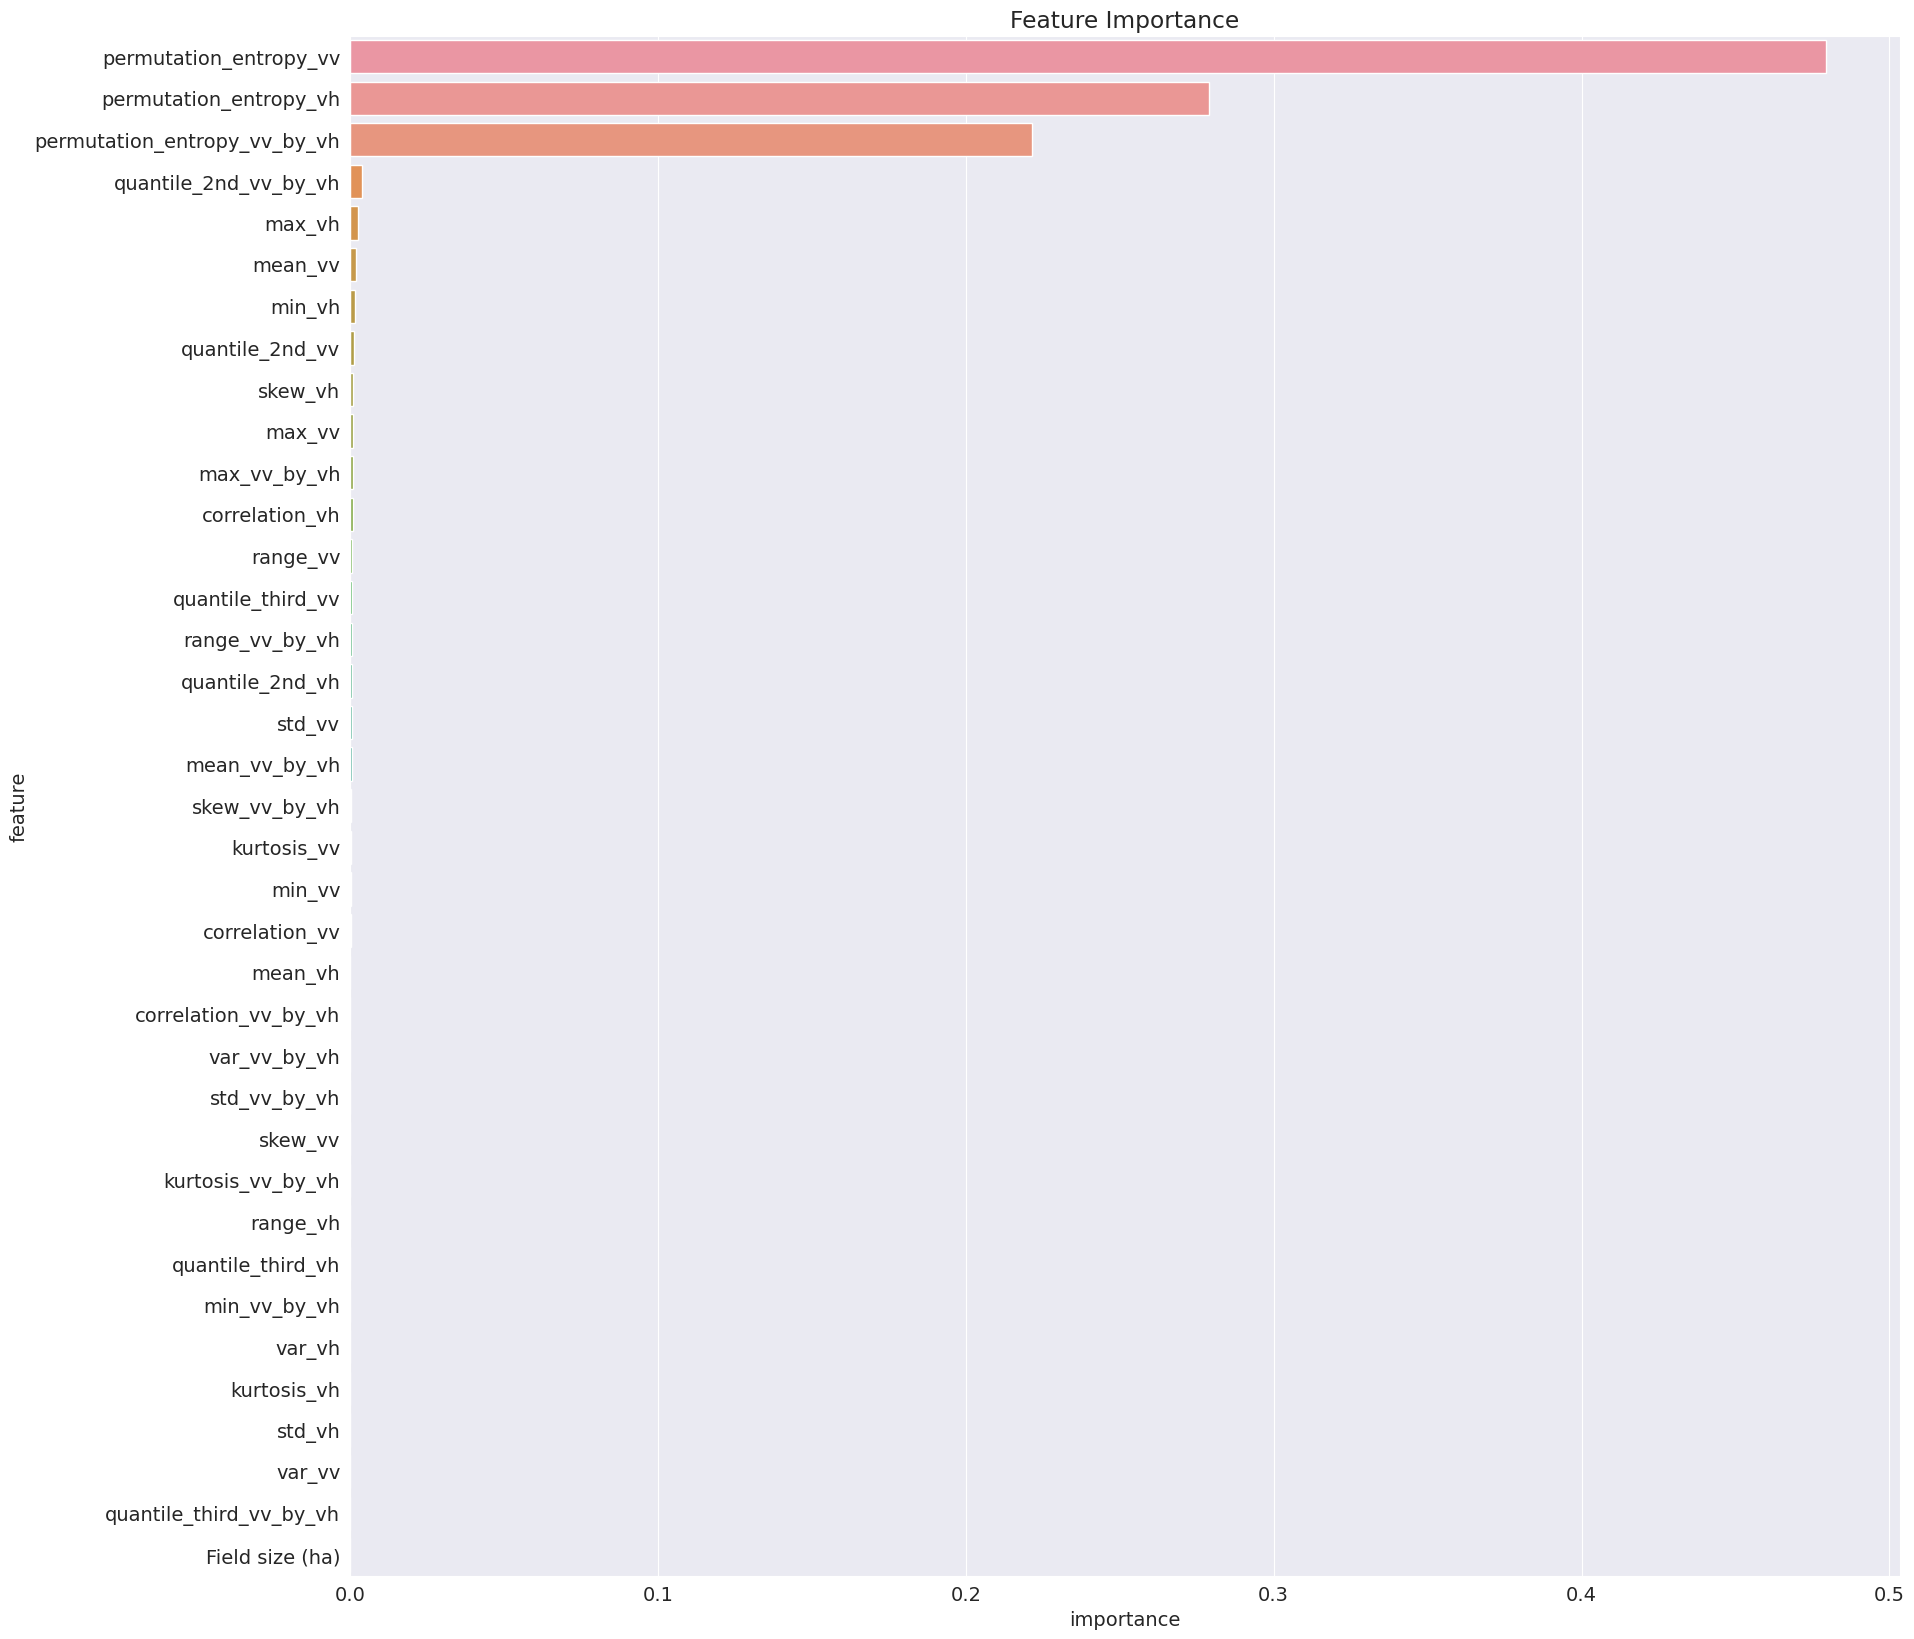

In [74]:
plot_importance(importance_df)

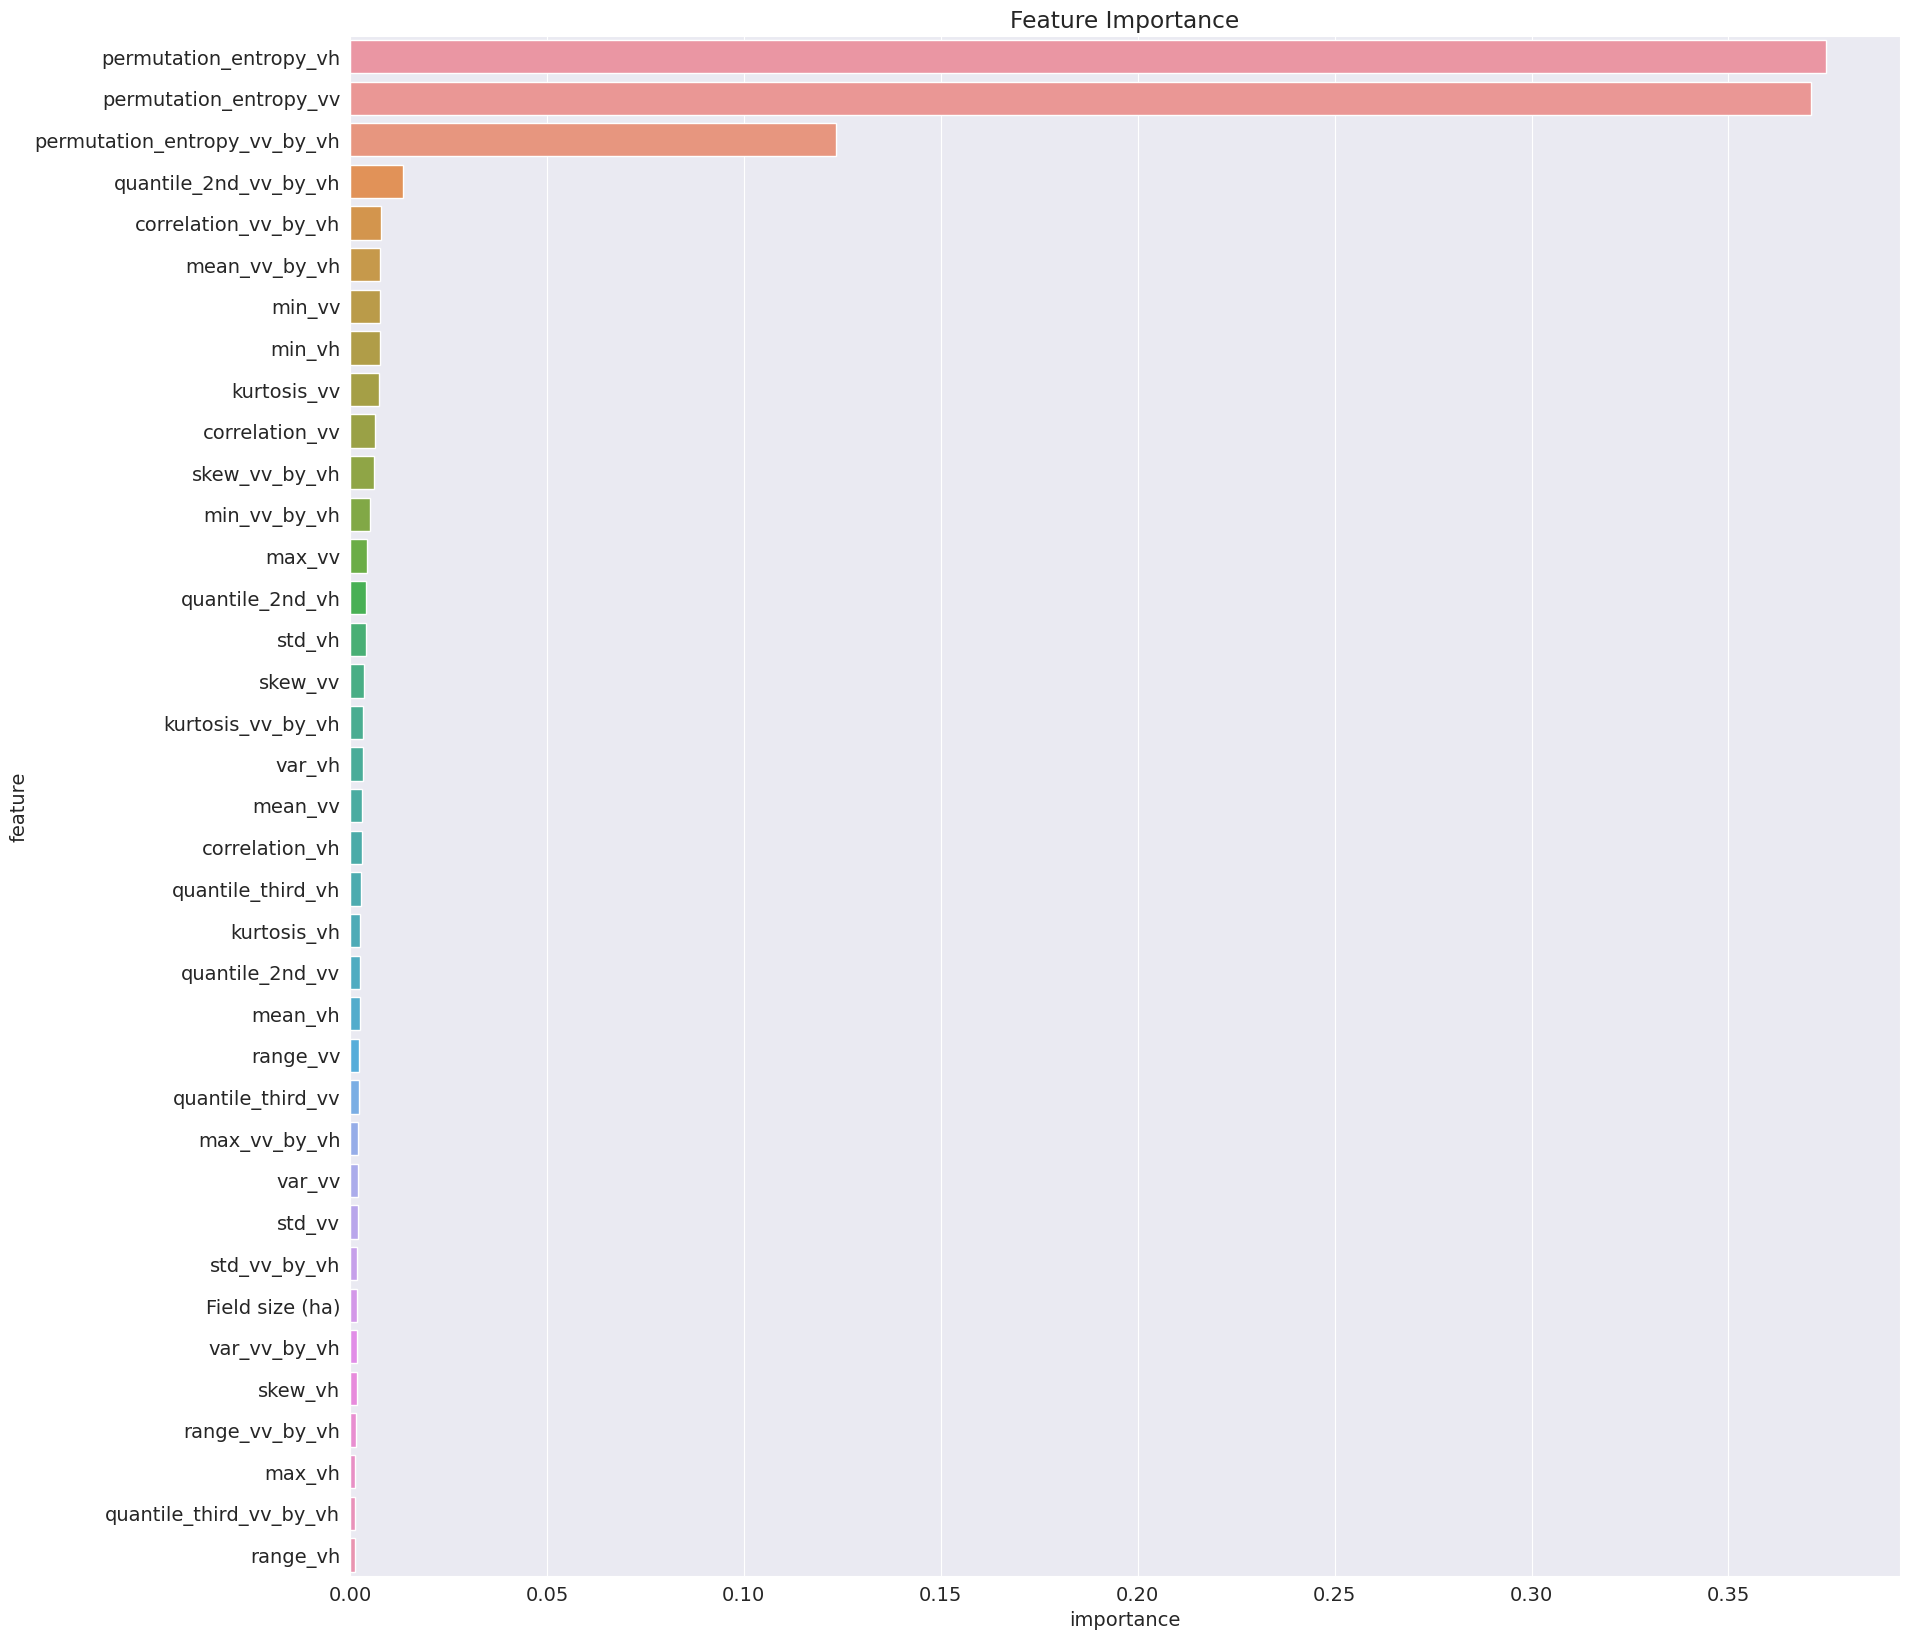

In [77]:
plot_importance(importance_adaboost)

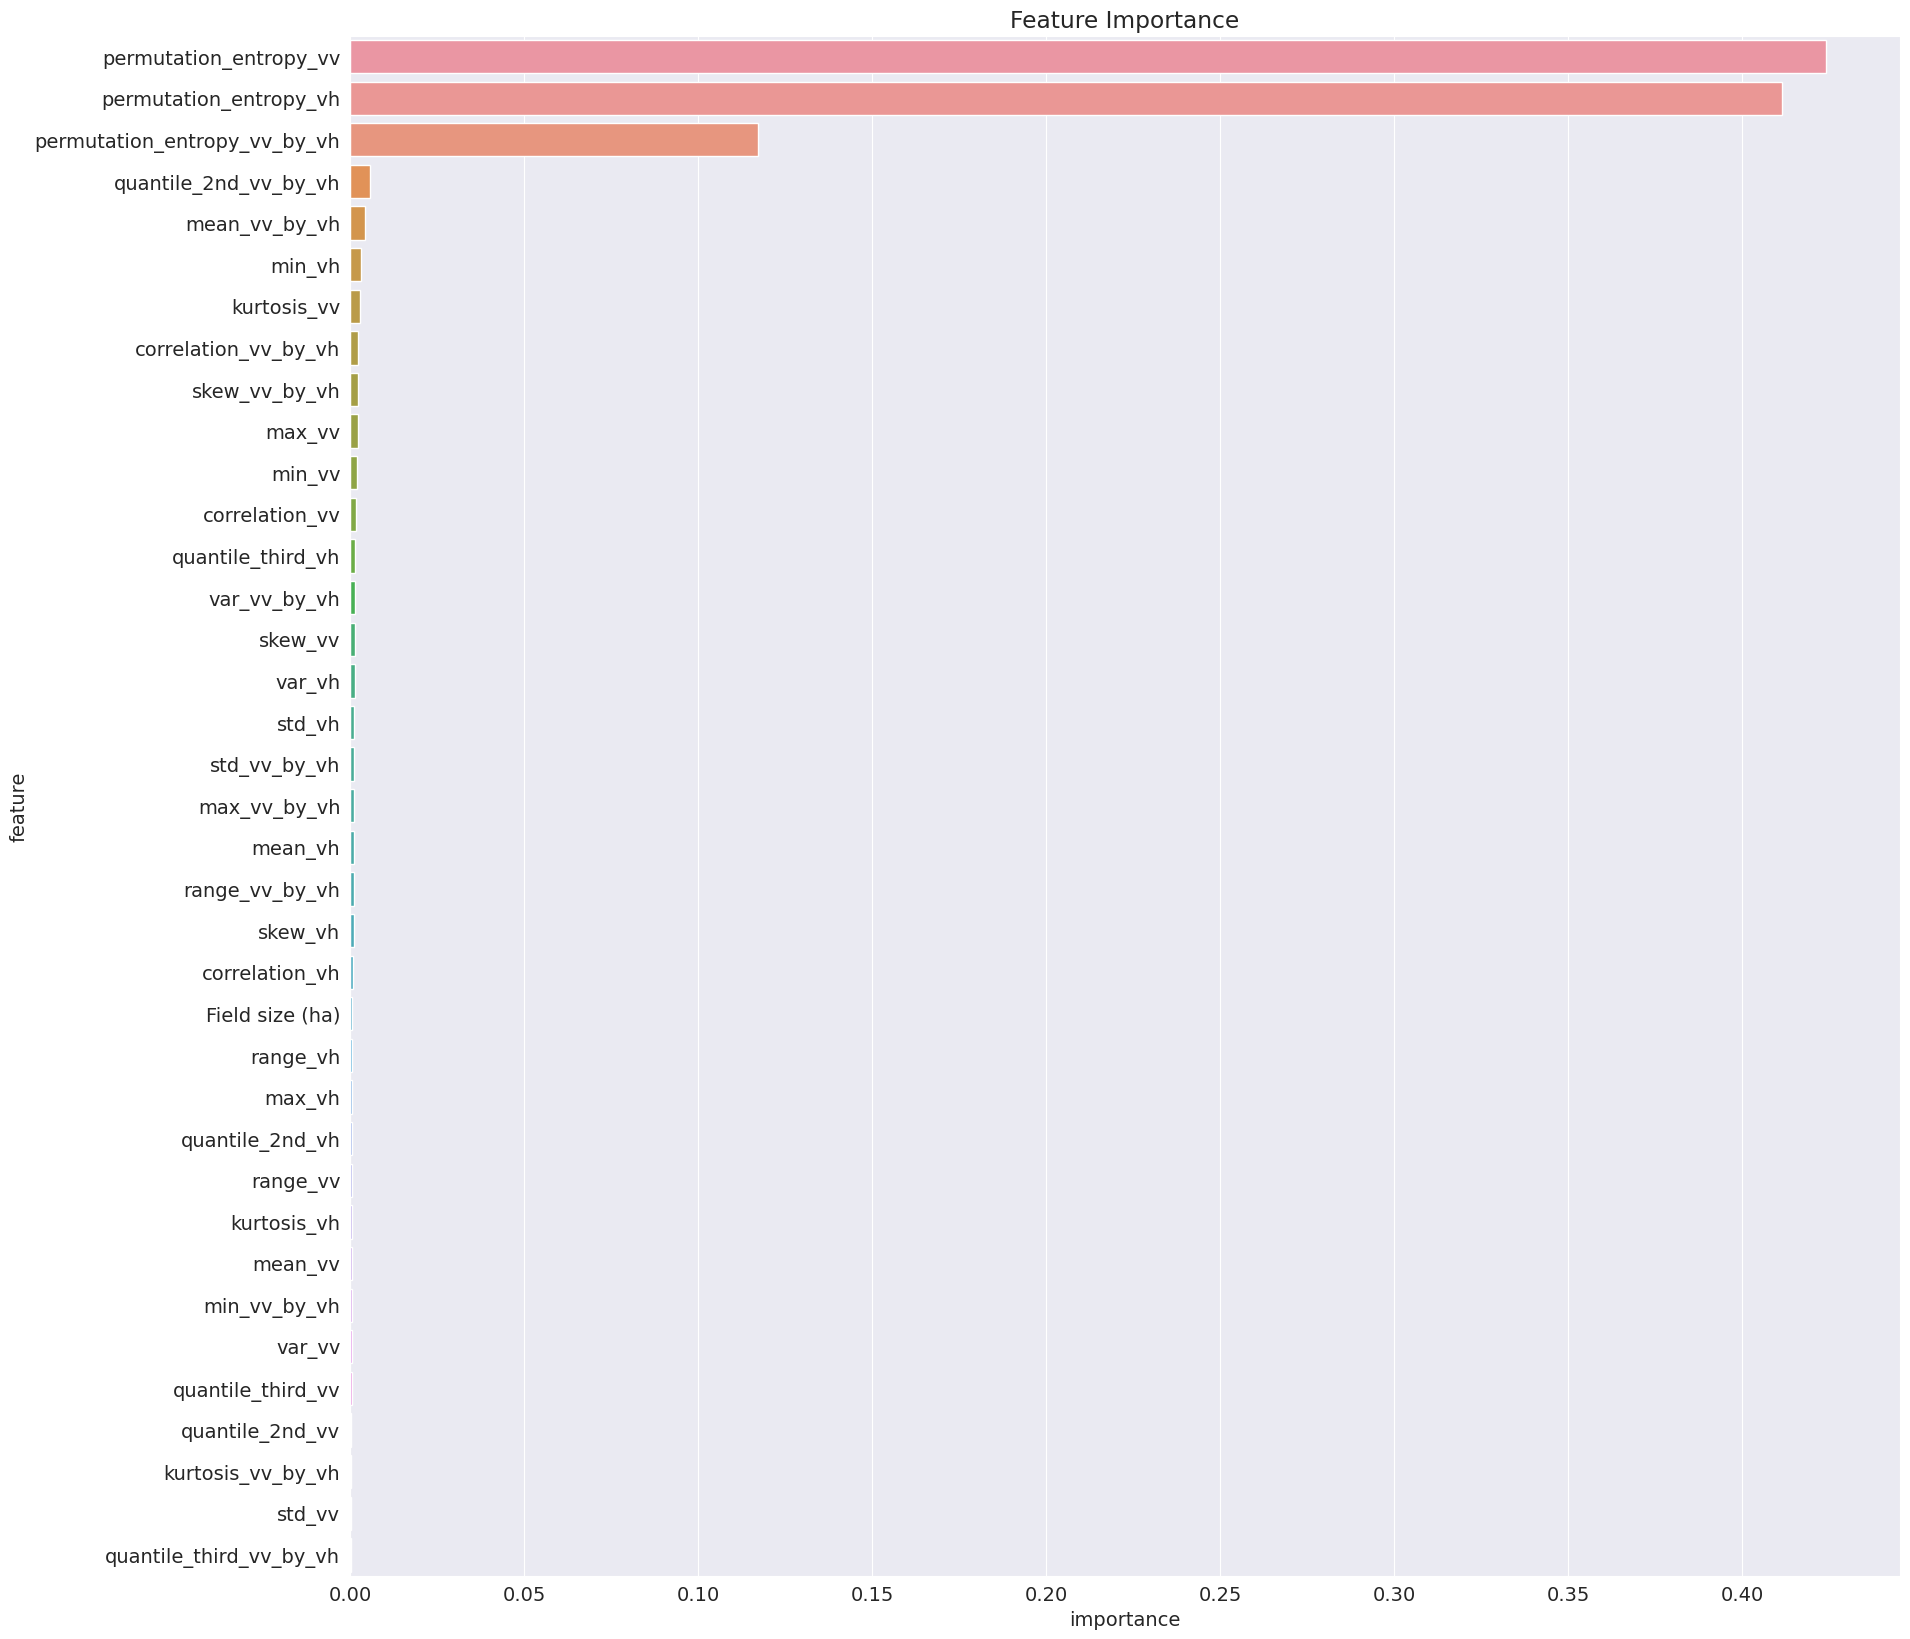

In [79]:
plot_importance(importance_rf)

## Hybrid Model 

In [87]:
# Combine predictions using weighted average
hybrid_predictions_train = (extra_train + rf_pred + ad_pred) / 3

# Evaluate performance
# Evaluation training sets
print("Hybrid Model training : {0:.2f}".format(r2_score(y_train,hybrid_predictions_train)))


Hybrid Model training : 0.71


In [88]:
# Combine predictions using weighted average
hybrid_predictions_test = (extra_test + test_pred_rf + test_pred_ad) / 3

# Evaluate performance
# Evaluation training sets
print("Hybrid Model test : {0:.2f}".format(r2_score(y_test,hybrid_predictions_test)))


Hybrid Model test : 0.65


## Submission

Once you are happy with your model, you can make a submission. To make a submission, you will need to use your model to make the yield predictions of rice crop for a set of test coordinates we have provided in the <a href="https://challenge.ey.com/api/v1/storage/admin-files/8515054086281302-63ca8f827b1fe300146c7e21-challenge_2_submission_template.csv"><b>"challenge_2_submission_template.csv"</b></a> file and upload the file onto the challenge platform.

In [76]:
test_file = pd.read_csv('Challenge_2_submission_template.csv')
test_file.head()

,ID No,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Predicted Rice Yield (kg/ha)
0,1,Chau_Phu,10.542192,105.187920,WS,T,10-04-2022,1.40,NaN
1,2,Chau_Thanh,10.400189,105.331053,SA,T,15-07-2022,1.32,NaN
2,3,Chau_Phu,10.505489,105.203926,SA,D,14-07-2022,1.40,NaN
3,4,Chau_Phu,10.523520,105.138274,WS,D,10-04-2022,1.80,NaN
4,5,Thoai_Son,10.294660,105.248528,SA,T,20-07-2022,2.20,NaN


In [78]:
# Get Sentinel-1-RTC Data
assests = ['vh','vv']
submission_band_values=test_file.progress_apply(lambda x: get_sentinel_data(x['Longitude'], x['Latitude'],x['Season(SA = Summer Autumn, WS = Winter Spring)'],assests), axis=1)
submission_vh = [x[0] for x in submission_band_values]
submission_vv = [x[1] for x in submission_band_values]
submission_vv_by_vh = [x[2] for x in submission_band_values]
submission_vh_vv_data = pd.DataFrame(list(zip(submission_vh,submission_vv,submission_vv_by_vh)),columns = ["vv_list","vh_list","vv/vh_list"])

  0%|          | 0/100 [00:00<?, ?it/s]

In [79]:
submission_vh_vv_data


,vv_list,vh_list,vv/vh_list
0,"[-32768.0, 0.0364215224981308, 0.0534569974988...","[-32768.0, 0.007165694842115045, 0.00943518988...","[1.0, 5.082762146675581, 5.66570446743536, 9.4..."
1,"[0.0987127386033535, 0.1108611710369587, 0.142...","[0.014903890434652567, 0.013173035811632872, 0...","[6.6232866536538415, 8.415764795770098, 10.948..."
2,"[0.09435706585645676, 0.08066679164767265, 0.0...","[0.017084279097616673, 0.0152529152110219, 0.0...","[5.523034675172215, 5.288614702937709, 10.1799..."
3,"[0.01368327671661973, 0.1782212257385254, 0.14...","[0.0038078136276453733, 0.01173835713416338, 0...","[3.5934733300172095, 15.182808267081034, 9.943..."
4,"[0.06013097986578941, 0.04305699095129967, 0.2...","[0.006932367105036974, 0.0066266346257179976, ...","[8.673946280499049, 6.497565262493167, 16.3085..."
...,...,...,...
95,"[0.13447758555412292, 0.14133238792419434, 0.2...","[0.014235780574381351, 0.015186136588454247, 0...","[9.446449729362097, 9.30667172002436, 16.07477..."
96,"[0.010695673059672117, 0.0938127376139164, 0.1...","[0.003464160952717066, 0.011935177724808455, 0...","[3.087521973043174, 7.860187738881951, 7.35975..."
97,"[0.08049548789858818, 0.12278065085411072, 0.2...","[0.009691183920949697, 0.008533219806849957, 0...","[8.306053063813893, 14.38854894556329, 19.3150..."
98,"[0.07825279608368874, 0.06675246730446815, 0.1...","[0.008372739888727665, 0.008849028963595629, 0...","[9.346139629757465, 7.543479355654025, 20.4171..."


In [80]:

submission_vh_vv_data.to_csv("submission.csv",index = False)

In [87]:
# Generating Statistical Features for VV,VH and VV/VH and creating a dataframe
features = generate_stastical_features(submission_vh_vv_data)
submission_features_data = pd.DataFrame(features ,columns = ['min_vv', 'max_vv', 'range_vv', 'mean_vv', 'correlation_vv', 'permutation_entropy_vv', 'std_vv','skew_vv', 'kurtosis_vv','quantile_2nd_vv',
                                                  'quantile_third_vv', "var_vv", 'min_vh', 'max_vh', 'range_vh', 'mean_vh', 'correlation_vh', 'permutation_entropy_vh', 'std_vh', 'skew_vh','kurtosis_vh','quantile_2nd_vh',
                                                  'quantile_third_vh', "var_vh", 'min_vv_by_vh', 'max_vv_by_vh', 'range_vv_by_vh', 'mean_vv_by_vh', 'correlation_vv_by_vh', 'permutation_entropy_vv_by_vh', 'std_vv_by_vh','skew_vv_by_vh','kurtosis_vv_by_vh', 
                          'quantile_2nd_vv_by_vh','quantile_third_vv_by_vh', "var_vv_by_vh"] )

In [88]:
submission_features_data.head()

,min_vv,max_vv,range_vv,mean_vv,correlation_vv,permutation_entropy_vv,std_vv,skew_vv,kurtosis_vv,quantile_2nd_vv,...,range_vv_by_vh,mean_vv_by_vh,correlation_vv_by_vh,permutation_entropy_vv_by_vh,std_vv_by_vh,skew_vv_by_vh,kurtosis_vv_by_vh,quantile_2nd_vv_by_vh,quantile_third_vv_by_vh,var_vv_by_vh
0,-32768.000000,0.259851,32768.259851,-2047.901319,-0.004164,0.364463,7931.895373,-3.614784,11.066667,0.055355,...,10.268704,4.737190,0.551125,0.364463,2.934186,0.959980,-0.293810,2.642506,5.949300,8.609446
1,0.039685,0.277786,0.238101,0.118242,0.583203,0.430629,0.060944,1.337308,1.248782,0.074577,...,12.081812,5.784922,0.709630,0.430629,3.565185,0.906137,-0.429544,2.873534,8.277971,12.710545
2,0.019513,0.239122,0.219609,0.114660,0.418326,0.430629,0.060285,0.543882,-0.969473,0.070191,...,23.935426,6.654509,0.389861,0.430629,5.621583,2.104235,4.257417,2.970533,7.258286,31.602192
3,0.013683,0.200710,0.187026,0.106832,0.151666,0.364463,0.052793,0.358192,-0.915110,0.068288,...,13.068003,4.800770,0.504533,0.318923,3.389863,1.930582,2.947541,3.054042,5.053431,11.491174
4,0.041902,0.270132,0.228229,0.117837,0.461667,0.430629,0.067051,0.873951,-0.484425,0.063635,...,14.084631,6.419432,0.658903,0.430629,3.972829,0.991665,-0.056445,3.087333,8.130887,15.783373


In [89]:
submission_features_data.to_csv("test_teamgh.csv",index = False)

In [312]:
 submission_features_data = scaler.fit_transform(submission_features_data)

In [313]:
 submission_features_data 

array([[-0.44946262, -0.75259682, -0.72058138, ..., -1.39043072,
        -1.74739548,  1.99968539],
       [ 0.63724187,  1.19345014,  1.14926074, ...,  1.34303738,
         0.99259317,  0.81833053],
       [-0.81892328, -0.59642194, -0.53072547, ..., -0.61112741,
        -0.89213203, -0.1746463 ],
       ...,
       [ 1.46064996, -0.02614966, -0.15368668, ...,  0.67159064,
         0.3786952 ,  0.39837474],
       [-0.45439796, -0.86595596, -0.83458785, ...,  0.59391865,
         0.72524461,  1.1260965 ],
       [-1.369045  , -0.93163985, -0.82118903, ..., -0.1201831 ,
        -0.66957084, -0.041112  ]])

In [314]:
#Making predictions
final_predictions = forest.predict(submission_features_data)
final_prediction_series = pd.Series(final_predictions)

In [315]:
#Combining the results into dataframe
test_file['Predicted Rice Yield (kg/ha)']=list(final_prediction_series)

In [316]:
#Dumping the predictions into a csv file.
test_file.to_csv("Wed_67.csv",index = False)

Now that you have learned a basic approach to model training, it’s time to try your own approach! Feel free to modify any of the functions presented in this notebook. We look forward to seeing your version of the model and the results. Best of luck with the challenge!